In [119]:
!pip install tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set.zip -d /content/training_set

Archive:  /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set.zip
  inflating: /content/training_set/S001_128.mat  
  inflating: /content/training_set/S001_128_ann.mat  
  inflating: /content/training_set/S001_128_rpk.mat  
  inflating: /content/training_set/S002_128.mat  
  inflating: /content/training_set/S002_128_ann.mat  
 extracting: /content/training_set/S002_128_rpk.mat  
  inflating: /content/training_set/S003_128.mat  
  inflating: /content/training_set/S003_128_ann.mat  
  inflating: /content/training_set/S003_128_rpk.mat  
  inflating: /content/training_set/S004_128.mat  
  inflating: /content/training_set/S004_128_ann.mat  
 extracting: /content/training_set/S004_128_rpk.mat  
  inflating: /content/training_set/S005_128.mat  
  inflating: /content/training_set/S005_128_ann.mat  
  inflating: /content/training_set/S005_128_rpk.mat  
  inflating: /content/training_set/S006_128.mat  
  inflating: /content/training_set/S006_128_ann.mat  
  inflating: /co

In [4]:
input_dir = "/content/training_set"

In [5]:
import os

# list the data present in the dataset
os.listdir(input_dir)

['S027_128_rpk.mat',
 'S031_128.mat',
 'S107_250_ann.mat',
 'S050_128_ann.mat',
 'S115_250.mat',
 'S046_128_ann.mat',
 'S098_250_rpk.mat',
 'S060_128_ann.mat',
 'S056_128.mat',
 'S009_128_ann.mat',
 'S108_250_rpk.mat',
 'S006_128_ann.mat',
 'S017_128_ann.mat',
 'S098_250_ann.mat',
 'S100_250_ann.mat',
 'S093_250.mat',
 'S054_128_ann.mat',
 'S079_250.mat',
 'S101_250_rpk.mat',
 'S052_128_rpk.mat',
 'S033_128.mat',
 'S106_250_ann.mat',
 'S048_128_rpk.mat',
 'S025_128.mat',
 'S063_128_ann.mat',
 'S114_250_ann.mat',
 'S020_128.mat',
 'S043_128_rpk.mat',
 'S110_250.mat',
 'S024_128.mat',
 'S087_250.mat',
 'S105_250_rpk.mat',
 'S109_250.mat',
 'S115_250_rpk.mat',
 'S055_128_rpk.mat',
 'S049_128_ann.mat',
 'S096_250.mat',
 'S054_128.mat',
 'S112_250.mat',
 'S012_128.mat',
 'S009_128_rpk.mat',
 'S113_250_ann.mat',
 'S061_128.mat',
 'S111_250_rpk.mat',
 'S085_250_rpk.mat',
 'S081_250.mat',
 'S013_128_ann.mat',
 'S094_250.mat',
 'S100_250.mat',
 'S052_128.mat',
 'S088_250.mat',
 'S109_250_ann.ma

Each data sample present:

*   sample.mat : 2-lead ECG signal of a patient of lenght n
*   sample_ann.mat : contains the annotations for each R peak

*   sample_rpk.mat : contains the R peak locations of the signal





# Data loading

In [125]:
# environment setup
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [7]:
# Utility function to load data

def load_data(ecg_file):
  ecg = loadmat(ecg_file)
  rpk_file = ecg_file.replace('.mat', '_rpk.mat')
  rpk = loadmat(rpk_file)
  ann_file = ecg_file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)
  return ecg, rpk, ann

In [126]:
# Get the ecg file for each sample and create a list of all ecgs
ecg_files = []

for f in os.listdir(input_dir):
  g = os.path.join(input_dir, f)
  if ('ann' not in g) and ('rpk' not in g):
    ecg_files.append(g)
num_files = len(ecg_files)

# Create lists that will contains each data types (ecg, labels, rpeaks) an filenames (a list which contains the original filename for each sample)
filenames = list()
ecgs = list()
rpks = list()
anns = list()

for i in tqdm(range(num_files)):
  ecg, rpk, ann = load_data(ecg_files[i])
  ecgs.append(ecg)
  rpks.append(rpk)
  anns.append(ann)
  filenames.append(ecg_files[i])


#ecg = np.asarray(loadmat(g)['ecg'], dtype=np.float64)
#rpk = np.asarray(loadmat(input_dir + "/S083_250_rpk.mat")['rpeaks'], dtype=np.float64)
#ann = np.asarray(loadmat(input_dir + "/S083_250_ann.mat")['labels'])

100%|██████████| 105/105 [00:02<00:00, 39.54it/s]


# Plot label distribution

In [127]:
classes_name = ['N', 'S', 'V']

In [128]:
# list which contains all labels of each beat
all_labels = []

for sample in anns:
  for beat in sample['labels']:
    all_labels.append(beat)

len(all_labels)

# create a counts of each labels
values, counts = np.unique(all_labels, return_counts=True)
values, counts

(array(['N', 'S', 'V'], dtype='<U1'), array([226932,   9609,   7795]))

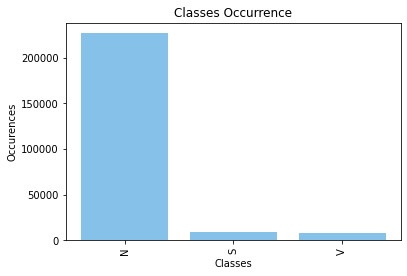

In [129]:
# Plot labels distribution (of all beats of all patients)
plt.bar(x=classes_name,height=counts, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

In [12]:
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [13]:
import neurokit2 as nk

In [130]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [132]:
# Exploration over some intervals of various single-beat signal

# lists that will contain PR and QR intervals
PR_N = list()
PR_S = list()
PR_V = list()
P_N = list()
P_S = list()
P_V = list()

QR_N = list()
QR_S = list()
QR_V = list()

# interval lists filling loop
for i in tqdm(range(len(ecgs))):
  # extract a sample ecg
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64)
  sampling = ecg_freq(filenames[i])
  ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
  #Extract peaks from traning set and their labels
  sample_labels = anns[i]['labels']
  sample_rpeaks = rpks[i]['rpeaks']

  # clean ecg_sample
  ecg_signal = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2')

  
  #_,rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling)
  # Building the dictionary with the rpeaks as the function of Neurokit wants
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling}
  _, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=sampling, method="dwt")
 
  #create waves_peak in time domain in order to plot the value in the time domain
  waves_peak_td = dict()

  #init the dictionary
  for k in waves_peak.keys():
    waves_peak_td[k] = list()

  for k in waves_peak.keys():
    for i in range(len(waves_peak[k])):
      if(math.isnan(waves_peak[k][i]) == False): #if is not nan, I divide the value for the frequency
        waves_peak_td[k].append(waves_peak[k][i] / sampling)
      else:
        waves_peak_td[k].append(waves_peak[k][i])  

  # add to the correct interval list the invterval of each beat of the current ecg sample

  for beat_index in range(len(sample_labels)):
    if sample_labels[beat_index] == 'N':
      try:
        P_N.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        P_N.append(math.nan)
      try:
        PR_N.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid index; Adding nan")
        PR_N.append(math.nan)
      try:  
        QR_N.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid index; Adding nan")
        QR_N.append(math.nan)
    elif sample_labels[beat_index] == 'S':
      try:
        P_S.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        P_S.append(math.nan)  
      try:
        PR_S.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid index; Adding nan")
        PR_S.append(math.nan)
      try:  
        QR_S.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid index; Adding nan")
        QR_S.append(math.nan)
    else:
      try:
        P_V.append(ecg_signal[waves_peak['ECG_P_Peaks'][beat_index]])
      except:
        P_V.append(math.nan)  
      try:
        PR_V.append(sample_rpeaks[beat_index] / sampling - waves_peak_td['ECG_P_Onsets'][beat_index] )
      except:
        print("Not valid index; Adding nan")
        PR_V.append(math.nan)
      try: 
        QR_V.append(waves_peak_td['ECG_T_Offsets'][beat_index] - sample_rpeaks[beat_index] / sampling)
      except:
        print("Not valid index; Adding nan")
        QR_V.append(math.nan)  

  6%|▌         | 6/105 [03:11<50:31, 30.62s/it]Exception ignored in: <function tqdm.__del__ at 0x7f1e6f03bb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 289, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
 10%|▉         | 10/105 [05:06<45:35, 28.80s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 11/105 [05:51<53:07, 33.91s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-pack

Not valid index; Adding nan


 62%|██████▏   | 65/105 [31:43<21:21, 32.05s/it]

Not valid index; Adding nan


 64%|██████▍   | 67/105 [32:47<20:42, 32.71s/it]

Not valid index; Adding nan


 65%|██████▍   | 68/105 [33:19<19:54, 32.27s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|██████▋   | 70/105 [34:15<17:07, 29.36s/it]

Not valid index; Adding nan


ValueError: ignored

In [133]:
print(len(PR_N))
print(len(PR_V))
print(len(PR_S))

153666
4722
4562


In [192]:
#Flatten the structure of the array
PR_N = [item for sublist in PR_N for item in sublist]
PR_V = [item for sublist in PR_V for item in sublist]
PR_S = [item for sublist in PR_S for item in sublist]

TypeError: ignored

In [194]:
#Flatten the structure of the array
QR_N = [item for sublist in QR_N for item in sublist]
QR_V = [item for sublist in QR_V for item in sublist]
QR_S = [item for sublist in QR_S for item in sublist]

TypeError: ignored

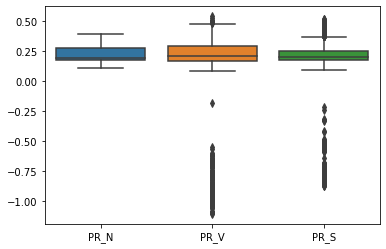

In [196]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'PR_N': PR_N[0:len(PR_S)], 'PR_V': PR_V[0:len(PR_S)], 'PR_S': PR_S })
sns.boxplot(data=df)


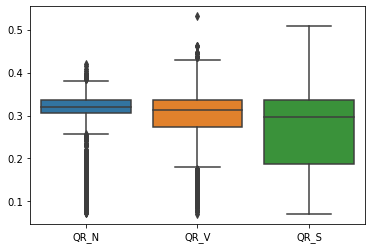

In [197]:
df1 = pd.DataFrame({'QR_N': QR_N[0:len(QR_S)], 'QR_V': QR_V[0:len(QR_S)], 'QR_S': QR_S})
sns.boxplot(data = df1)

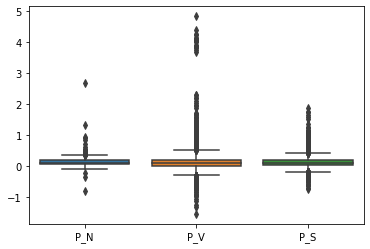

In [198]:
df2 = pd.DataFrame({'P_N': P_N[0:len(P_S)], 'P_V': P_V[0:len(P_S)], 'P_S': P_S})
sns.boxplot(data = df2)